In [1]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np
import math

gas_factor = 15

file_list = ("Arith", "./monte_carlo_arith_deterministic_parallel.csv")

def get_df(file):
    (name, path) = file;
    df = pd.read_csv(path)
        
    return df

data = get_df(file_list)

data.head()

,modulus_limbs,group_limbs,num_mul_pairs,a_is_zero,ext_degree,run_microseconds_add,run_microseconds_mul,run_microseconds_multiexp
0,4,1,128,0,1,73,69,1250
1,4,1,64,0,1,15,83,752
2,4,1,32,0,1,16,81,531
3,4,1,16,0,1,12,79,307
4,4,1,8,0,1,11,79,218


In [2]:
from sklearn import linear_model
from sklearn.linear_model import Lasso
from scipy.optimize import nnls

def split(df):
    g1 = df[df["ext_degree"] == 1]
    g1_a_non_zero = g1[g1["a_is_zero"] == 0].copy()
    g1_a_is_zero = g1[g1["a_is_zero"] == 1].copy()
    
    g2_ext_2 = df[df["ext_degree"] == 2]
    g2_ext_2_a_non_zero = g2_ext_2[g2_ext_2["a_is_zero"] == 0].copy()
    g2_ext_2_a_is_zero = g2_ext_2[g2_ext_2["a_is_zero"] == 1].copy()
    
    g2_ext_3 = df[df["ext_degree"] == 3]
    g2_ext_3_a_non_zero = g2_ext_3[g2_ext_3["a_is_zero"] == 0].copy()
    g2_ext_3_a_is_zero = g2_ext_3[g2_ext_3["a_is_zero"] == 1].copy()
    
    
    return (g1_a_non_zero, g1_a_is_zero, g2_ext_2_a_non_zero, g2_ext_2_a_is_zero, g2_ext_3_a_non_zero, g2_ext_3_a_is_zero)

(g1_a_non_zero, g1_a_is_zero, g2_ext_2_a_non_zero, g2_ext_2_a_is_zero, g2_ext_3_a_non_zero, g2_ext_3_a_is_zero) = split(data)

g1_a_non_zero.head()


,modulus_limbs,group_limbs,num_mul_pairs,a_is_zero,ext_degree,run_microseconds_add,run_microseconds_mul,run_microseconds_multiexp
0,4,1,128,0,1,73,69,1250
1,4,1,64,0,1,15,83,752
2,4,1,32,0,1,16,81,531
3,4,1,16,0,1,12,79,307
4,4,1,8,0,1,11,79,218


In [3]:
def make_diffs(non_zero, is_zero):
    diff = non_zero.copy();
    diff["run_microseconds_add"] -= is_zero["run_microseconds_add"]
    diff["run_microseconds_mul"] -= is_zero["run_microseconds_mul"]
    diff["run_microseconds_multiexp"] -= is_zero["run_microseconds_multiexp"]
    
    return diff
    
diff = make_diffs(g1_a_non_zero, g1_a_is_zero)

g1_a_is_zero.head()

# diff.head()

,modulus_limbs,group_limbs,num_mul_pairs,a_is_zero,ext_degree,run_microseconds_add,run_microseconds_mul,run_microseconds_multiexp
7,4,1,128,1,1,17,87,1185
8,4,1,64,1,1,16,64,837
9,4,1,32,1,1,14,67,491
10,4,1,16,1,1,12,76,310
11,4,1,8,1,1,12,72,213


In [4]:
def fit_add_and_mul(df):
    addition = df[["modulus_limbs","run_microseconds_add"]].groupby(['modulus_limbs']).mean()
    addition["gas_add"] = addition["run_microseconds_add"].apply(lambda x: gas_factor * math.ceil(x))
    addition.drop('run_microseconds_add', axis=1, inplace=True)
#     addition = df[["modulus_limbs","run_microseconds_add"]].groupby(['modulus_limbs']).median()
    multiplication = df[["modulus_limbs","group_limbs", "run_microseconds_mul"]].groupby(['modulus_limbs', 'group_limbs']).mean()
#     multiplication = df[["modulus_limbs","group_limbs", "run_microseconds_mul"]].groupby(['modulus_limbs', 'group_limbs']).median()
    
    return (addition.copy(), multiplication.copy())

(g1_add_is_zero, g1_m_is_zero) = fit_add_and_mul(g1_a_is_zero)
(g1_add_non_zero, g1_m_non_zero) = fit_add_and_mul(g1_a_non_zero)

In [5]:
def merge_max(non_zero, zero):
    result = non_zero.copy()
    result["gas_add_non_zero"] = result["gas_add"]
    result.drop("gas_add", axis = 1, inplace = True)
    result["gas_add_zero"] = zero["gas_add"]
    result["gas_add"] = result[["gas_add_non_zero", "gas_add_zero"]].apply(lambda x: max(x["gas_add_non_zero"], x["gas_add_zero"]), axis=1)
    result.drop("gas_add_non_zero", axis = 1, inplace = True)
    result.drop("gas_add_zero", axis = 1, inplace = True)

    return result

In [6]:
def merge_max_mul(this, other):
    result = this.copy()
    result["base_1"] = result["base_gas"]
    result.drop("base_gas", axis = 1, inplace = True)
    result["base_2"] = other["base_gas"]
    result["base_gas"] = result[["base_1", "base_2"]].max(axis = 1)
    
    result["gas_per_group_limb_1"] = result["gas_per_group_limb"]
    result.drop("gas_per_group_limb", axis = 1, inplace = True)
    result["gas_per_group_limb_2"] = other["gas_per_group_limb"]
    result["gas_per_group_limb"] = result[["gas_per_group_limb_1", "gas_per_group_limb_2"]].max(axis = 1)
    
    result.drop("base_1", axis = 1, inplace = True)
    result.drop("base_2", axis = 1, inplace = True)
    
    result.drop("gas_per_group_limb_1", axis = 1, inplace = True)
    result.drop("gas_per_group_limb_2", axis = 1, inplace = True)

    return result

In [7]:
g1_add = merge_max(g1_add_non_zero, g1_add_is_zero)

g1_add.head(15)

,gas_add
modulus_limbs,
4,315
5,405
6,435
7,480
8,630
9,720
10,885
11,1020
12,1080


In [8]:
def fit_mul(df):
    
    results = []
    for limbs, g in df.groupby(["modulus_limbs"]):
        g = g.copy()
        g.reset_index(inplace=True) 
        model = Lasso(alpha=0.0001,precompute=True,max_iter=1000,
            positive=True, random_state=9999, selection='random')
        model.fit(g["group_limbs"][:, np.newaxis], g["run_microseconds_mul"][:, np.newaxis])

        score = model.score(g["group_limbs"][:, np.newaxis], g["run_microseconds_mul"][:, np.newaxis])

        print("R^2 = {}".format(score))

        slope = math.ceil(model.coef_[0]) * gas_factor;
        intercept = math.ceil(model.intercept_[0]) * gas_factor;
        
        results.append([limbs, slope, intercept])
        
    result_df = pd.DataFrame(results, columns = ["modulus_limbs", "gas_per_group_limb", "base_gas"])
    
    return result_df

In [9]:
results_mul_g1 = merge_max_mul(fit_mul(g1_m_is_zero), fit_mul(g1_m_non_zero))

results_mul_g1.head(16)

R^2 = 0.9570430801461519
R^2 = 0.9956619765787561
R^2 = 0.992346561937069
R^2 = 0.997546566958313
R^2 = 0.9990080818491184
R^2 = 0.9993942187379306
R^2 = 0.997988358446992
R^2 = 0.9996125033635873
R^2 = 0.9994311062928415
R^2 = 0.9994172318493574
R^2 = 0.999694271965816
R^2 = 0.9992521033238326
R^2 = 0.9992548643660876
R^2 = 0.9883651829970734
R^2 = 0.9981470135494258
R^2 = 0.9964778094437671
R^2 = 0.9967598221418307
R^2 = 0.9996382811042189
R^2 = 0.9996197595564901
R^2 = 0.9957506408660991
R^2 = 0.9991463819348457
R^2 = 0.9995173635243668
R^2 = 0.9977415188135159
R^2 = 0.9988707589829724
R^2 = 0.9983253164920659
R^2 = 0.9996823966198172


,modulus_limbs,base_gas,gas_per_group_limb
0,4,540,990
1,5,600,1290
2,6,1125,1590
3,7,1230,2025
4,8,1065,2535
5,9,1605,3210
6,10,1665,3795
7,11,2010,4350
8,12,1740,5100
9,13,1770,6000


In [10]:
(g2_ext2_add_is_zero, g2_ext2_m_is_zero) = fit_add_and_mul(g2_ext_2_a_is_zero)
(g2_ext2_add_non_zero, g2_ext2_m_non_zero) = fit_add_and_mul(g2_ext_2_a_non_zero)

In [11]:
g2_ext2_add = merge_max(g2_ext2_add_non_zero, g2_ext2_add_is_zero)

g2_ext2_add.head(15)

,gas_add
modulus_limbs,
4,1395
5,2100
6,2625
7,3375
8,4125
9,5145
10,6180
11,7200
12,8460


In [12]:
results_mul_g2_ext_2 = merge_max_mul(fit_mul(g2_ext2_m_is_zero), fit_mul(g2_ext2_m_non_zero))

results_mul_g2_ext_2.head(16)

R^2 = 0.993739900690019
R^2 = 0.9992555275606491
R^2 = 0.9909891880376076
R^2 = 0.9978076241750025
R^2 = 0.9997915417120683
R^2 = 0.9995791608319265
R^2 = 0.9985566842442548
R^2 = 0.9990190190588588
R^2 = 0.9999733906891758
R^2 = 0.999315313010633
R^2 = 0.9998222507579341
R^2 = 0.9998343007149365
R^2 = 0.9999362339875135
R^2 = 0.9834558705792609
R^2 = 0.9998322493082269
R^2 = 0.9998219958961877
R^2 = 0.9996530783985792
R^2 = 0.9998989029977611
R^2 = 0.9987835419099628
R^2 = 0.9960968725164718
R^2 = 0.9998382789957124
R^2 = 0.9998913167159027
R^2 = 0.9994443419848695
R^2 = 0.9998469156921371
R^2 = 0.9998800744967783
R^2 = 0.9996552639488149


,modulus_limbs,base_gas,gas_per_group_limb
0,4,1590,4260
1,5,2475,5595
2,6,3870,7035
3,7,4605,8700
4,8,4605,11190
5,9,5340,14445
6,10,6105,17190
7,11,7485,19845
8,12,7935,23490
9,13,8715,27120


In [13]:
(g2_ext3_add_is_zero, g2_ext3_m_is_zero) = fit_add_and_mul(g2_ext_3_a_is_zero)
(g2_ext3_add_non_zero, g2_ext3_m_non_zero) = fit_add_and_mul(g2_ext_3_a_non_zero)

In [14]:
g2_ext3_add = merge_max(g2_ext3_add_non_zero, g2_ext3_add_is_zero)

g2_ext3_add.head(15)

,gas_add
modulus_limbs,
4,1380
5,1995
6,2550
7,3075
8,4080
9,5070
10,6165
11,7185
12,8415


In [15]:
results_mul_g2_ext_3 = merge_max_mul(fit_mul(g2_ext3_m_is_zero), fit_mul(g2_ext3_m_non_zero))

results_mul_g2_ext_3.head(16)

R^2 = 0.9974155373471457
R^2 = 0.9998518575358161
R^2 = 0.9995926610706328
R^2 = 0.9924101832648936
R^2 = 0.9998250907311269
R^2 = 0.9999089354748897
R^2 = 0.9986495664910517
R^2 = 0.9997756359888114
R^2 = 0.9995949574594037
R^2 = 0.998952212461614
R^2 = 0.9999075721028893
R^2 = 0.999751122012158
R^2 = 0.9997294439563578
R^2 = 0.9927563167394586
R^2 = 0.9988348696972327
R^2 = 0.9998394404609886
R^2 = 0.9987740398801113
R^2 = 0.9999132402447929
R^2 = 0.9994006527425824
R^2 = 0.9990076795588787
R^2 = 0.9998625026877952
R^2 = 0.9999169003388014
R^2 = 0.9992794740802606
R^2 = 0.9995476579717882
R^2 = 0.9994805263428845
R^2 = 0.9980200021075125


,modulus_limbs,base_gas,gas_per_group_limb
0,4,1650,8070
1,5,2190,10635
2,6,3000,13500
3,7,2115,17430
4,8,3825,22065
5,9,5010,28170
6,10,6795,32430
7,11,7215,37995
8,12,7155,44175
9,13,5235,51255


In [16]:
from sklearn import linear_model
from sklearn.linear_model import Lasso
from scipy.optimize import nnls

def correct_and_fit(df, base_costs, skip_bad_fits = False):
    min_score = 1.0
    
    df_miller_loops = pd.DataFrame(columns = df.columns);
    df_miller_loops.drop("num_pairs", axis = 1, inplace = True);
    df_miller_loops.drop("run_microseconds", axis = 1, inplace = True);
    df_miller_loops["miller_gas"] = 0.0
    
    for (k, g) in df.groupby(['modulus_limbs', "group_limbs"]):
        g = g.copy()
        g["gas"] = g["run_microseconds_multiexp"].apply(lambda x: gas_factor * math.ceil(x))
        g.drop("run_microseconds_multiexp", axis = 1, inplace = True)
        g["gas_naive"] = g[["modulus_limbs","group_limbs", "num_pairs"]].apply(lambda x: eval_naive(x["modulus_limbs"], x["group_limbs"], x["group_limbs"], base_costs), axis=1)

        model = Lasso(alpha=0.0001,precompute=True,max_iter=1000,
            positive=True, random_state=9999, selection='random', fit_intercept = False)
        model.fit(g["num_pairs"][:, np.newaxis], g["gas_corrected"][:, np.newaxis])
        
        score = model.score(g["num_pairs"][:, np.newaxis], g["gas_corrected"][:, np.newaxis])
        if score < min_score:
            min_score = score
            
        if score < 0.85 and skip_bad_fits:
#             print(g["num_pairs"])
#             print(g["run_microseconds"])
            continue
            
        slope = model.coef_[0];
        intercept = model.intercept_;
#         intercept = model.intercept_[0];
        
#         if slope <= 1 or intercept <= 1:
#             continue
            
        g_miller = g.iloc[0].copy()
        g_miller.drop("gas_corrected", inplace = True)

        g_miller["miller_gas"] = slope;

        g_miller.drop("num_pairs", inplace = True)
        g_miller.drop("gas", inplace = True)

        df_miller_loops = df_miller_loops.append(g_miller, verify_integrity=True)
        
    print("Min score = {}".format(min_score))
        
    return df_miller_loops



In [37]:
def eval_naive(modulus_limbs, group_limbs, num_pairs, base_costs):
    base = base_costs[base_costs["modulus_limbs"] == modulus_limbs]["base_gas"].array[0]
    per_group_limb = base_costs[base_costs["modulus_limbs"] == modulus_limbs]["gas_per_group_limb"].array[0] * group_limbs
    
    final = num_pairs*(base + per_group_limb)
    
    return final

def estimate_naive(df, base_costs):
    g = df.copy()
    g["gas"] = g["run_microseconds_multiexp"].apply(lambda x: gas_factor * math.ceil(x))
    g.drop("run_microseconds_multiexp", axis = 1, inplace = True)
    g["gas_naive"] = g[["modulus_limbs","group_limbs", "num_mul_pairs"]].apply(lambda x: eval_naive(x["modulus_limbs"], x["group_limbs"], x["num_mul_pairs"], base_costs), axis=1)
    g["gas_factor"] = g[["gas_naive","gas"]].apply(lambda x: x["gas"] * 1.0 / (x["gas_naive"] * 1.0), axis=1)
    factors = g[["num_mul_pairs", "gas_factor"]].groupby(["num_mul_pairs"]).mean()
    factors.reset_index(inplace=True) 
    factors["log_factor"] = factors["gas_factor"].apply(lambda x: np.log(x))
#     factors = g[["num_mul_pairs", "gas_factor"]].groupby(["num_mul_pairs"]).max()
    return factors

multiexp_g1 = estimate_naive(g1_a_non_zero, fit_mul(g1_m_non_zero))

multiexp_g1.head(15)


R^2 = 0.9883651829970734
R^2 = 0.9981470135494258
R^2 = 0.9964778094437671
R^2 = 0.9967598221418307
R^2 = 0.9996382811042189
R^2 = 0.9996197595564901
R^2 = 0.9957506408660991
R^2 = 0.9991463819348457
R^2 = 0.9995173635243668
R^2 = 0.9977415188135159
R^2 = 0.9988707589829724
R^2 = 0.9983253164920659
R^2 = 0.9996823966198172


,num_mul_pairs,gas_factor,log_factor
0,2,0.846739,-0.166363
1,4,0.581579,-0.542008
2,8,0.392703,-0.934702
3,16,0.283287,-1.261294
4,32,0.222585,-1.502448
5,64,0.180999,-1.709262
6,128,0.141616,-1.954634


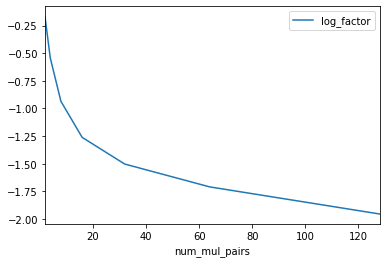

In [38]:
import matplotlib.pyplot as plt

plt.close('all')

multiexp_g1.plot(x = "num_mul_pairs", y = "log_factor")

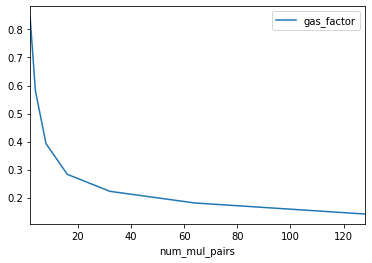

In [39]:
multiexp_g1.plot(x = "num_mul_pairs", y = "gas_factor")

In [34]:
import numpy as np
import scipy

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

def fit_exponential(df):
    # Create linear regression object
    regr = linear_model.LinearRegression()

    regr.fit(df["num_mul_pairs"], df["gas_factor"])
    
    pred = regr.predict(df["num_mul_pairs"])

    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean squared error
    print('Mean squared error: %.2f'
          % mean_squared_error(df["num_mul_pairs"], df["gas_factor"]))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'
          % r2_score(diabetes_y_test, df["gas_factor"]))
    
    
    X = df["num_mul_pairs"].to_numpy()
    Y = df["gas_factor"].to_numpy()
    log_Y = np.log(Y)
    res = np.polyfit(X, log_Y, 1)
    print(res)
    (res, _) = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  X,  Y, p0=(2, -1))
    print(res)
    
fit_exponential(multiexp_g1)

[-0.01148071 -0.73637291]
[ 0.81237183 -0.05917821]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
